# Data exploration

## Preliminaries

### Imports

In [1]:
import sys
import os
sys.path.append('./src')

In [2]:
import pickle
import bz2

In [3]:
from joblib import Parallel
from joblib import delayed
from joblib import parallel_backend

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
from statistics import mean, stdev

In [6]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
import pandas as pd
pd.set_option('display.max_rows', 80)

In [9]:
import numpy as np

In [10]:
import string

### Constants and global variables

In [11]:
SPLITS = ('train', 'validation', 'test')
DATA_SETS = ('DailyDialog', 'EmpatheticDialogues', 'Persona-Chat', 'Wizard of Wikipedia', 'HOPE')

In [12]:
DATA_PATH = '../resources/data/cache/'

In [13]:
TOP_WORDS = 20

In [14]:
SENTIMENT_MAP = {'Very negative': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3, 'Very Positive': 4}
SENTIMENT = ['Very negative', 'Negative', 'Neutral', 'Positive', 'Very positive']

In [15]:
DA_MAP = {
    'Clarification Request': 'Speaker Initiative',
    'Opinion Request': 'Speaker Initiative',
    'Information Request': 'Speaker Initiative',
    'Yes/No question': 'Speaker Initiative',
    'Greeting': 'General',
    'Acknowledgement': 'General',
    'General Chat': 'General',
    'Information Delivery': 'Speaker Responsive',
    'Positive Answer': 'Speaker Responsive',
    'Clarification Delivery': 'Speaker Responsive',
    'Negative Answer': 'Speaker Responsive',
    'Opinion Delivery': 'Speaker Responsive',
}

### Helper functions

In [16]:
def load_data(path):
    # Open the BZIP2 file
    with bz2.BZ2File(path, 'r') as f:
        # Read the content with Pickle
        data = pickle.load(f)
    # Return loaded data
    return data

In [17]:
def group_by(data, group):
    # Initialise a dictionary to store the groups
    grouped_data = {value: [] for value in {sample[group] for sample in data}}
    # Go through the data set and add each sample to the correct group
    for sample in data:
        if sample[group] in grouped_data:
            grouped_data[sample[group]].append(sample)
        else:
            grouped_data[sample[group]]= [sample]
    # Return grouped data
    return grouped_data

In [18]:
def compute_metadata(data):
    # Helper function to compute the desired info on a single sample
    def get_metadata(sample):
        return {'corpus': sample['corpus'], 'conversation_idx': sample['conversation_idx'], 'n_tokens': len(word_tokenize(sample['response']))}
    # Define parallel backend to compute the desired metadata
    with parallel_backend('threading', n_jobs=-1):
        # Compute No. of tokens for each turn of each dialogue in each corpus (mantaing the splitting info)
        metadata = Parallel(verbose=0)(delayed(get_metadata)(sample) for sample in data)
    # Return computed metadata
    return metadata

In [19]:
def compute_stats(data):
    # Group data by dialogue identifier
    grouped_data = group_by(data, 'conversation_idx')
    # Compute number of different dialogues
    n_dialogues = len(grouped_data)
    # Compute mean and standard deviation of dialogues length
    mean_n_turns = mean(len(group) for group in grouped_data.values())
    std_n_turns = stdev(len(group) for group in grouped_data.values())
    # Compute mean and standard deviation of tokens per turn length
    mean_n_tokens = mean(sample['n_tokens'] for sample in data)
    std_n_tokens = stdev(sample['n_tokens'] for sample in data)
    # Return computed statistics
    return n_dialogues, (mean_n_turns, std_n_turns), (mean_n_tokens, std_n_tokens)

## Data

### Load data

In [20]:
data = {
    split: load_data(os.path.join(DATA_PATH, f'evaluation_corpus_{split}.pbz2')) for split in SPLITS
}

### Compute stats

In [21]:
metadata = {split: compute_metadata(samples) for split, samples in data.items()}

In [22]:
for split, info in metadata.items():
    print(f'Split: {split}')
    for sub_set, sub_set_info in group_by(info, 'corpus').items():
        print(f'\tSub set: {sub_set}')
        n_dialogues, (mean_n_turns, std_n_turns), (mean_n_tokens, std_n_tokens) = compute_stats(sub_set_info)
        print(f'\t\tNo. of dialogues: {n_dialogues:5d}, No. of turns per dialogue: {mean_n_turns:3.1f}({std_n_turns:3.1f}), No. of tokens per turn: {mean_n_tokens:3.1f}({std_n_tokens:3.1f}),')
    print('\tTotal:')
    n_dialogues, (mean_n_turns, std_n_turns), (mean_n_tokens, std_n_tokens) = compute_stats(info)
    print(f'\t\tNo. of dialogues: {n_dialogues:5d}, No. of turns per dialogue: {mean_n_turns:3.1f}({std_n_turns:3.1f}), No. of tokens per turn: {mean_n_tokens:3.1f}({std_n_tokens:3.1f}),')
n_dialogues, (mean_n_turns, std_n_turns), (mean_n_tokens, std_n_tokens) = compute_stats(sum((info for info in metadata.values()), list()))
print('Total')
print(f'\tNo. of dialogues: {n_dialogues:5d}, No. of turns per dialogue: {mean_n_turns:3.1f}({std_n_turns:3.1f}), No. of tokens per turn: {mean_n_tokens:3.1f}({std_n_tokens:3.1f}),')

Split: train
	Sub set: EmpatheticDialogues
		No. of dialogues: 19533, No. of turns per dialogue: 4.3(0.7), No. of tokens per turn: 15.6(9.6),
	Sub set: HOPE
		No. of dialogues:   149, No. of turns per dialogue: 63.2(40.5), No. of tokens per turn: 26.5(36.8),
	Sub set: Wizard of Wikipedia
		No. of dialogues: 18430, No. of turns per dialogue: 9.0(1.0), No. of tokens per turn: 18.9(9.1),
	Sub set: Persona-Chat
		No. of dialogues:  8939, No. of turns per dialogue: 14.7(1.7), No. of tokens per turn: 11.7(4.1),
	Sub set: DailyDialog
		No. of dialogues: 11118, No. of turns per dialogue: 7.8(4.0), No. of tokens per turn: 14.0(10.5),
	Total:
		No. of dialogues: 19533, No. of turns per dialogue: 24.5(14.0), No. of tokens per turn: 15.6(10.4),
Split: validation
	Sub set: EmpatheticDialogues
		No. of dialogues:  2770, No. of turns per dialogue: 4.4(0.7), No. of tokens per turn: 16.7(9.5),
	Sub set: HOPE
		No. of dialogues:    21, No. of turns per dialogue: 56.9(27.8), No. of tokens per turn: 27.6(

### Visualise distributions

#### Words distribution

In [23]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize, stop_words=set(stopwords.words('english')) | set(string.punctuation), max_df=0.9, min_df=2).fit([sample['response'] for sample in data['train']])

/Users/vincenzoscotti_polimi/anaconda3/envs/dldlm/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/vincenzoscotti_polimi/anaconda3/envs/dldlm/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [24]:
data_vectors = {split: {corpus: tfidf.transform([sample['response'] for sample in samples]) for corpus, samples in group_by(samples, 'corpus').items()} for split, samples in data.items()}

In [42]:
vocabulary = tfidf.get_feature_names_out()

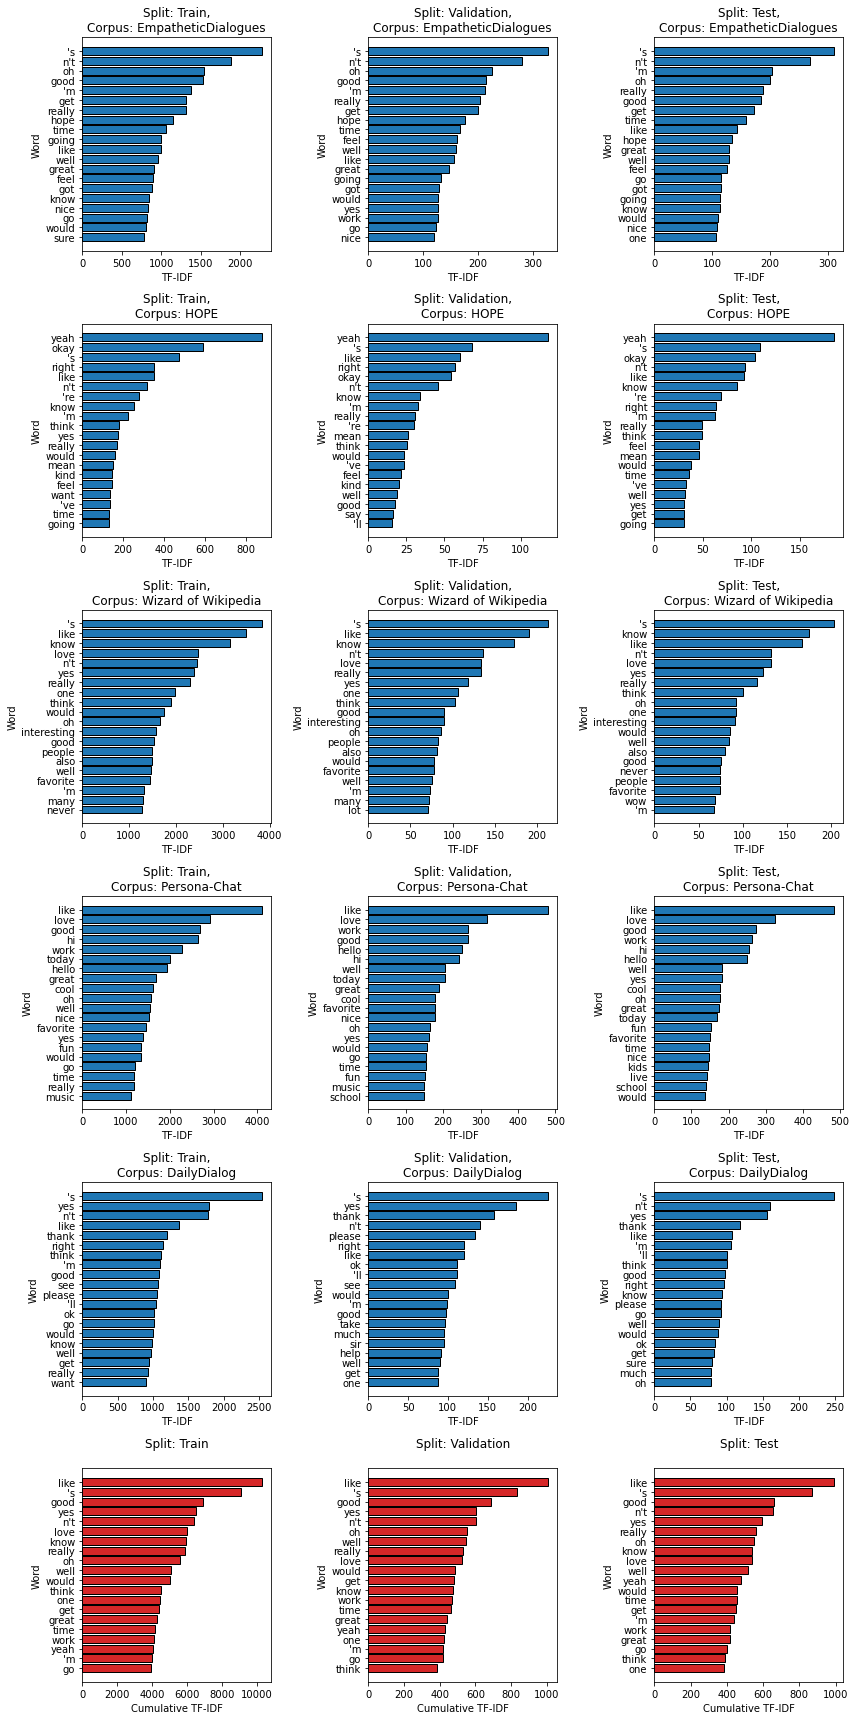

In [74]:
fig, axes = plt.subplots(nrows=len(data_vectors['train']) + 1, ncols=len(data_vectors), figsize=(12, 24))

for i, (split, split_data) in enumerate(data_vectors.items()):
    X = []
    for j, (corpus, corpus_data) in enumerate(split_data.items()):
        x = np.asarray(corpus_data.sum(0))[0]
        X.append(x.copy())
        idxs = x.argsort()[: -TOP_WORDS - 1 : -1][::-1]
        x = x[idxs]
        y = vocabulary[idxs]
        axes[j][i].barh(y, x, linewidth=1., edgecolor='0')
        axes[j][i].set_title(f'Split: {split.capitalize()},\nCorpus: {corpus}')
        axes[j][i].set_xlabel('TF-IDF')
        axes[j][i].set_ylabel('Word')
    x = sum(X)
    idxs = x.argsort()[: -TOP_WORDS - 1 : -1][::-1]
    x = x[idxs]
    y = vocabulary[idxs]
    axes[-1][i].barh(y, x, linewidth=1., edgecolor='0', color='tab:red')
    axes[-1][i].set_title(f'Split: {split.capitalize()}\n')
    axes[-1][i].set_xlabel('Cumulative TF-IDF')
    axes[-1][i].set_ylabel('Word')
plt.tight_layout()
plt.show()

#### Sentiment distribution

In [44]:
metadata =  {split: group_by(data[split], 'corpus') for split in data}

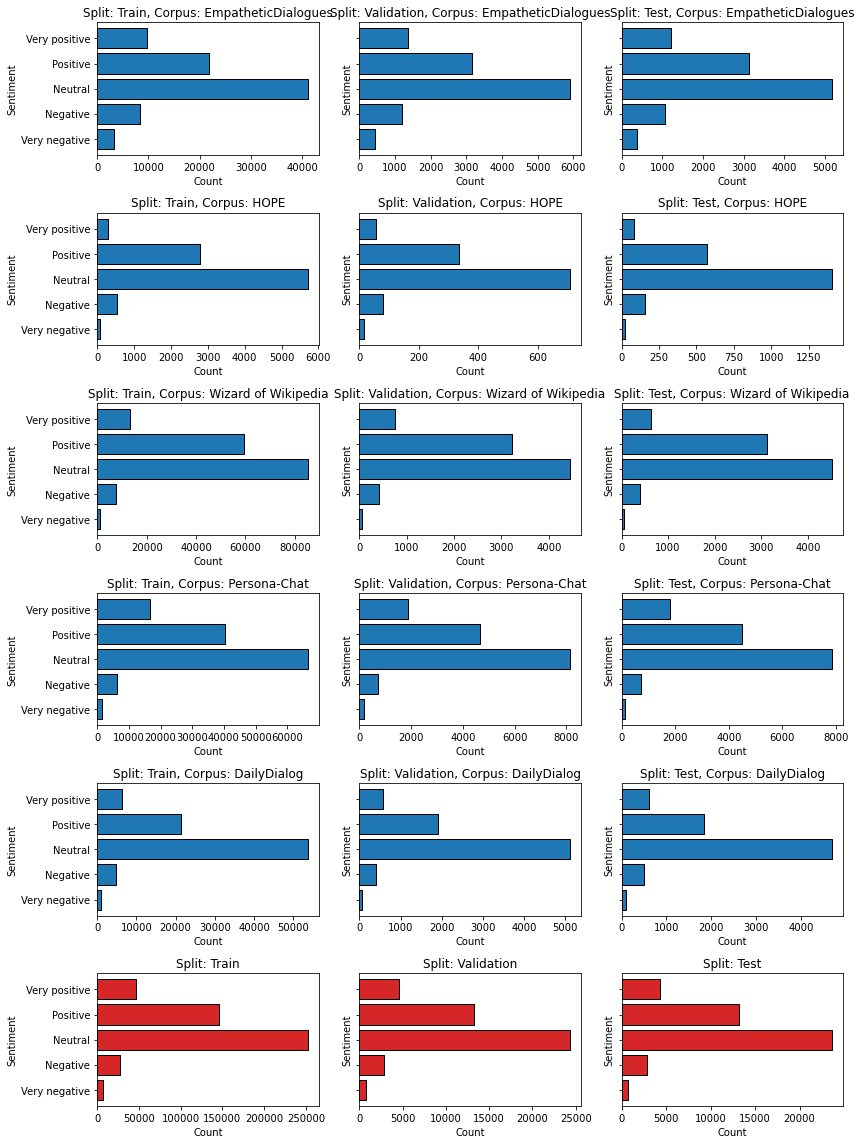

In [45]:
fig, axes = plt.subplots(nrows=len(metadata['train']) + 1, ncols=len(metadata), figsize=(12, 16), sharey=True)

for i, (split, split_data) in enumerate(metadata.items()):
    X = {sentiment: 0 for sentiment in SENTIMENT}
    for j, (corpus, corpus_data) in enumerate(split_data.items()):
        x = {SENTIMENT[SENTIMENT_MAP[sentiment]]: len(group) for sentiment, group in group_by(corpus_data, 'sentiment').items()}
        for sentiment in X:
            X[sentiment] += x[sentiment]
        axes[j][i].barh(SENTIMENT, [x[sentiment] for sentiment in SENTIMENT], linewidth=1., edgecolor='0')
        axes[j][i].set_title(f'Split: {split.capitalize()}, Corpus: {corpus}')
        axes[j][i].set_xlabel('Count')
        axes[j][i].set_ylabel('Sentiment')
        # axes[i][j].set_xscale('log')
    axes[-1][i].barh(SENTIMENT, [X[sentiment] for sentiment in SENTIMENT], linewidth=1., edgecolor='0', color='tab:red')
    axes[-1][i].set_title(f'Split: {split.capitalize()}')
    axes[-1][i].set_xlabel('Count')
    axes[-1][i].set_ylabel('Sentiment')
    # axes[i][-1].set_xscale('log')
plt.tight_layout()
plt.show()

#### Labels distribution

In [30]:
hope = {split: [sample for sample in data[split] if sample['corpus'] == 'HOPE'] for split in data}

In [31]:
hope_metadata = {split: [
    (sample['speaker'], 
     sample['dialogue_act'], 
     DA_MAP.get(sample['dialogue_act']), 
     len(word_tokenize(sample['response']))) 
    for sample in hope[spclit]
] for split in hope}

In [32]:
df = pd.DataFrame(
    data=[(split.capitalize(), *sample) for split in hope_metadata for sample in hope_metadata[split]],
    columns=['Split', 'Speaker', 'Dialogue act', 'Act type', 'No. of tokens']
)

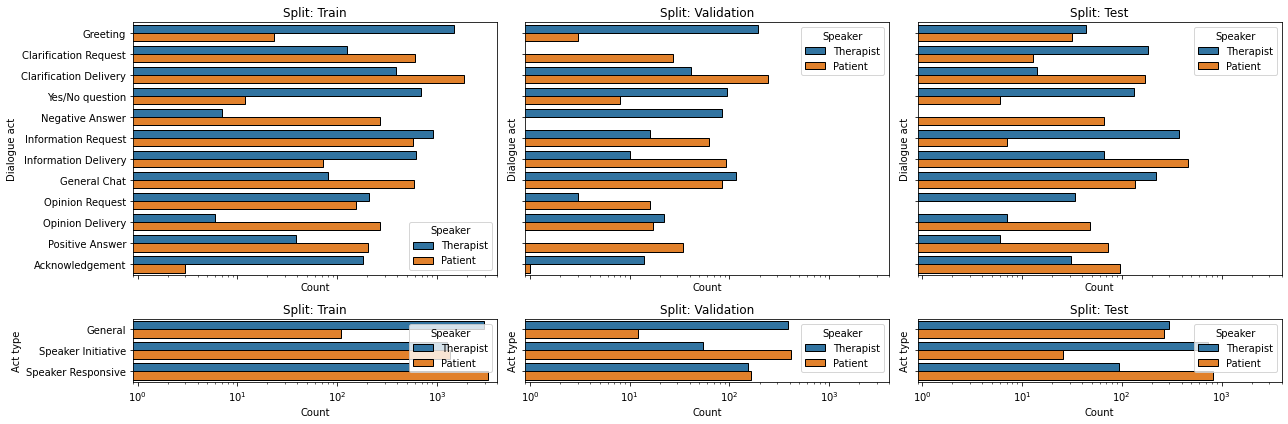

In [41]:
tmp_df_fine = df.groupby(['Split', 'Speaker', 'Dialogue act'], sort=False).size().reset_index()
tmp_df_coarse = df.groupby(['Split', 'Speaker', 'Act type'], sort=False).size().reset_index()

fig, axes = plt.subplots(
    nrows=2, 
    ncols=len(tmp_df_fine['Split'].unique()), 
    figsize=(18, 6), 
    sharex=True, 
    sharey='row', 
    gridspec_kw={'width_ratios': [1, 1, 1], 'height_ratios': [12, 3]}
)

for i, (split, split_df) in enumerate(tmp_df_fine.groupby('Split', sort=False)):
    sns.barplot(data=split_df, hue='Speaker', x=0, y='Dialogue act', ax=axes[0][i], linewidth=1., edgecolor='0', orient='h')
    axes[0][i].set_title(f'Split: {split}')
    axes[0][i].set_xlabel('Count')
    axes[0][i].set_xscale('log')
    axes[0][i].set_xlim(0.9, tmp_df_coarse[0].max() + 1000)
for i, (split, split_df) in enumerate(tmp_df_coarse.groupby('Split', sort=False)):
    sns.barplot(data=split_df, hue='Speaker', x=0, y='Act type', ax=axes[1][i], linewidth=1., edgecolor='0', orient='h')
    axes[1][i].set_title(f'Split: {split}')
    axes[1][i].set_xlabel('Count')
    axes[1][i].set_xscale('log')
    axes[1][i].set_xlim(0.9, 4000) 

plt.tight_layout()
plt.show()

In [79]:
hope_metadata = {split: [
    (sample['speaker'], 
     SENTIMENT[SENTIMENT_MAP[sample['sentiment']]]) 
    for sample in hope[split]
] for split in hope}

In [80]:
df = pd.DataFrame(
    data=[(split.capitalize(), *sample) for split in hope_metadata for sample in hope_metadata[split]],
    columns=['Split', 'Speaker', 'Sentiment']
)

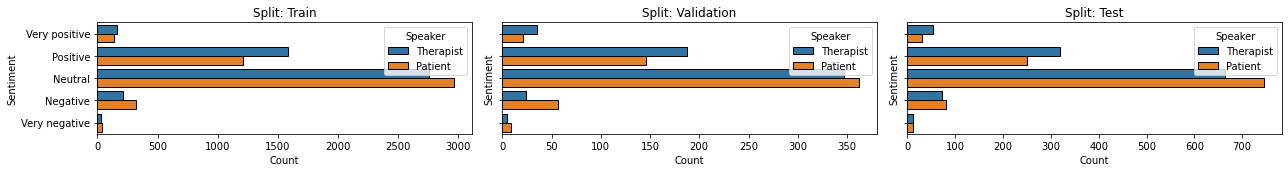

In [99]:
tmp_df = df.groupby(['Split', 'Speaker', 'Sentiment'], sort=False).size().reset_index()

fig, axes = plt.subplots(
    nrows=1, 
    ncols=len(tmp_df['Split'].unique()), 
    figsize=(18, 2.5),
    sharey=True
)

for i, (split, split_df) in enumerate(tmp_df.groupby('Split', sort=False)):
    sns.barplot(data=split_df, hue='Speaker', x=0, y='Sentiment', ax=axes[i], linewidth=1., edgecolor='0', orient='h', order=SENTIMENT[::-1])
    axes[i].set_title(f'Split: {split}')
    axes[i].set_xlabel('Count')
    
plt.tight_layout()
plt.show()

#### Speaker term distribution

In [46]:
hope_data_vectors = {
    split: {
        speaker: tfidf.transform([sample['response'] for sample in samples]) 
        for speaker, samples in group_by([s for s in samples if s['corpus'] == 'HOPE' and s['speaker'] is not None], 'speaker').items()
    } 
    for split, samples in data.items()
}

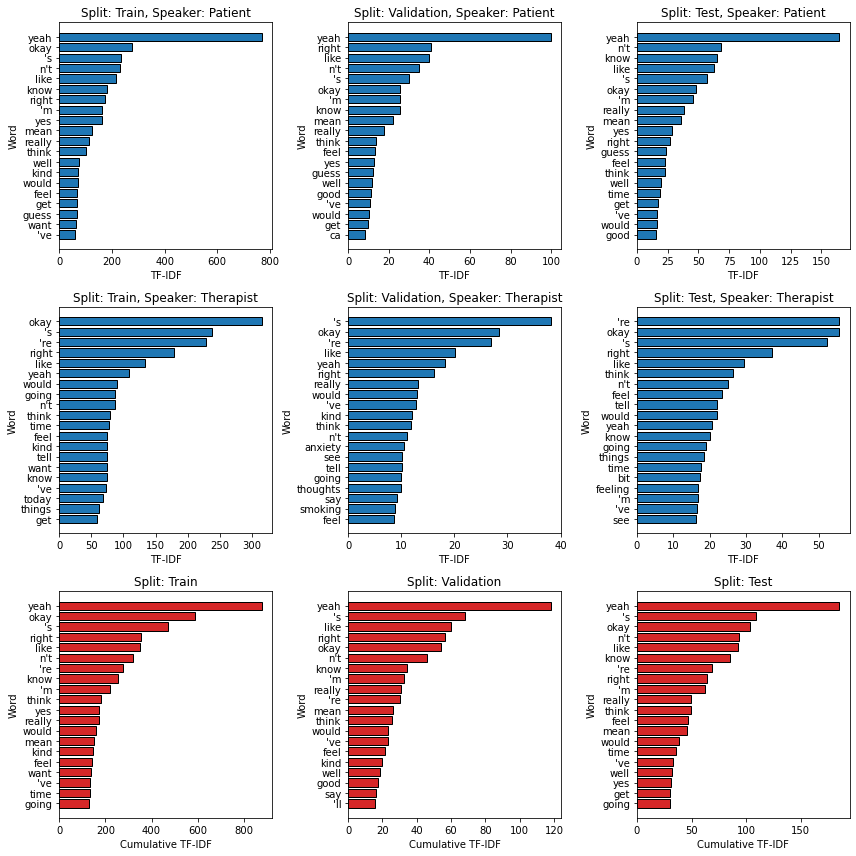

In [47]:
fig, axes = plt.subplots(nrows=len(hope_data_vectors), ncols=len(hope_data_vectors['train']) + 1, figsize=(12, 12))

for i, (split, split_data) in enumerate(hope_data_vectors.items()):
    X = []
    for j, (speaker, speaker_data) in enumerate(split_data.items()):
        x = np.asarray(speaker_data.sum(0))[0]
        X.append(x.copy())
        idxs = x.argsort()[: -TOP_WORDS - 1 : -1][::-1]
        x = x[idxs]
        y = vocabulary[idxs]
        axes[j][i].barh(y, x, linewidth=1., edgecolor='0')
        axes[j][i].set_title(f'Split: {split.capitalize()}, Speaker: {speaker}')
        axes[j][i].set_xlabel('TF-IDF')
        axes[j][i].set_ylabel('Word')
    x = sum(X)
    idxs = x.argsort()[: -TOP_WORDS - 1 : -1][::-1]
    x = x[idxs]
    y = vocabulary[idxs]
    axes[-1][i].barh(y, x, linewidth=1., edgecolor='0', color='tab:red')
    axes[-1][i].set_title(f'Split: {split.capitalize()}')
    axes[-1][i].set_xlabel('Cumulative TF-IDF')
    axes[-1][i].set_ylabel('Word')
plt.tight_layout()
plt.show()

#### Action and speaker term distribution

In [59]:
hope_data_vectors = {
    split: {
        action: {
            speaker: tfidf.transform([sample['response'] for sample in samples]) 
            for speaker, samples in group_by([s for s in samples if s['speaker'] is not None], 'speaker').items()
        }
        for action, samples in group_by([s for s in samples if s['corpus'] == 'HOPE' and s['dialogue_act'] is not None], 'dialogue_act').items()
    } 
    for split, samples in data.items()
}

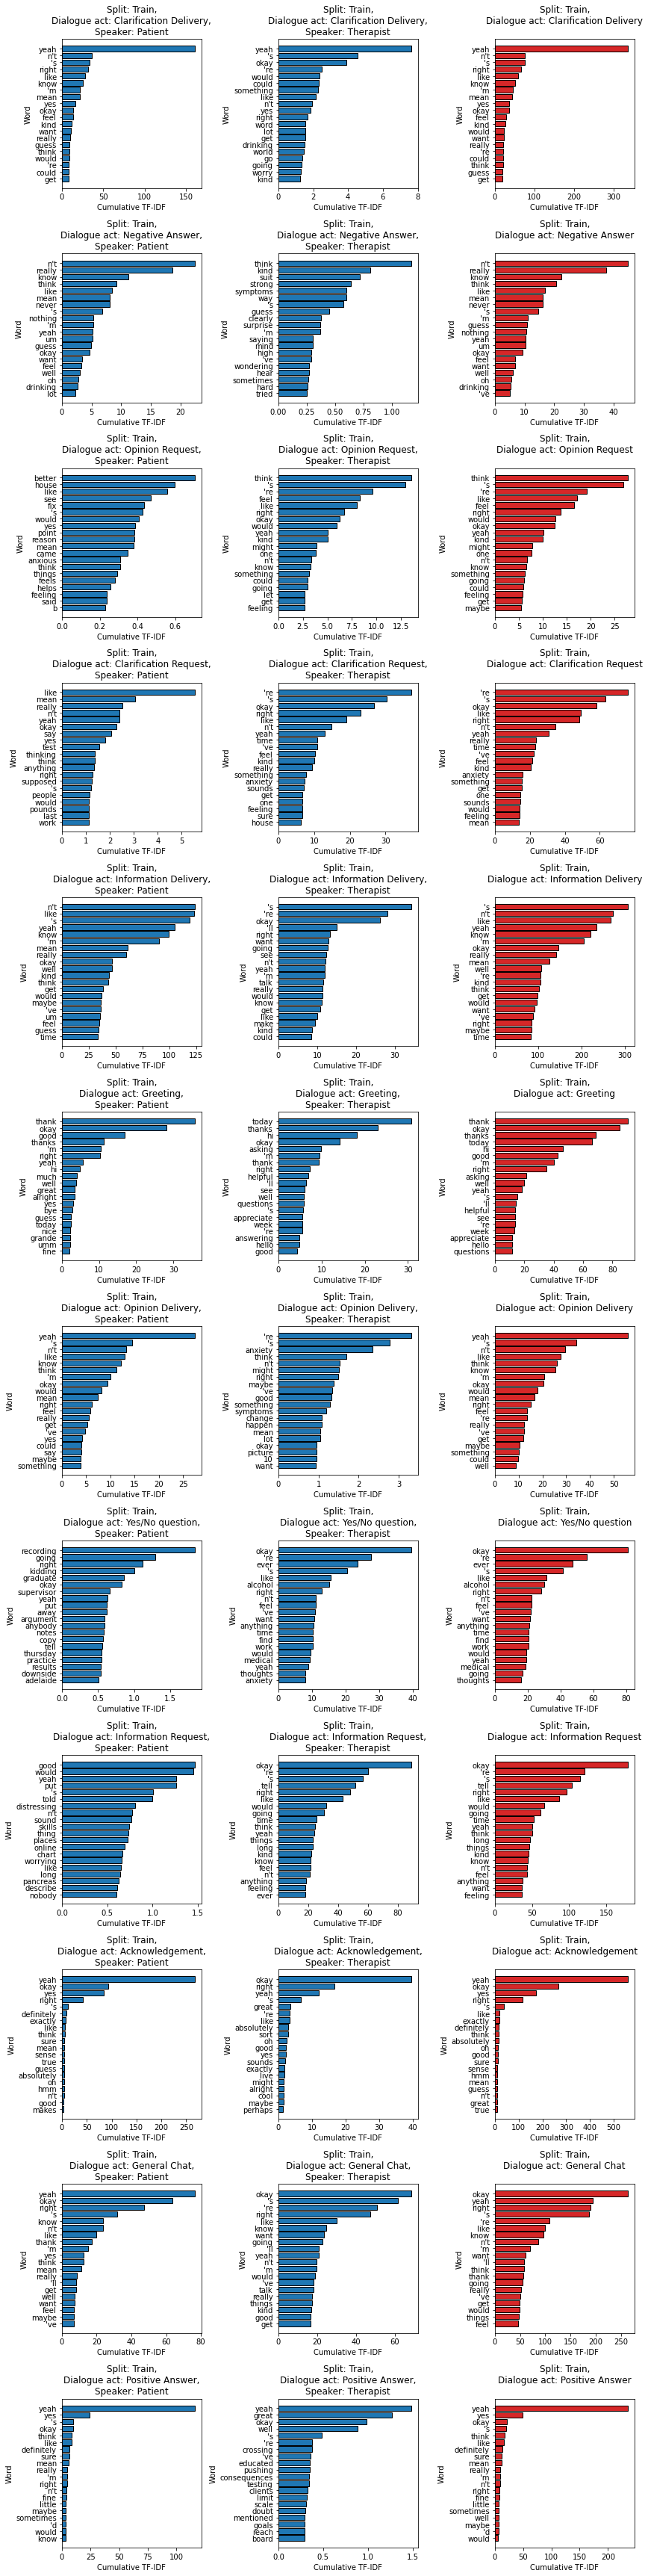

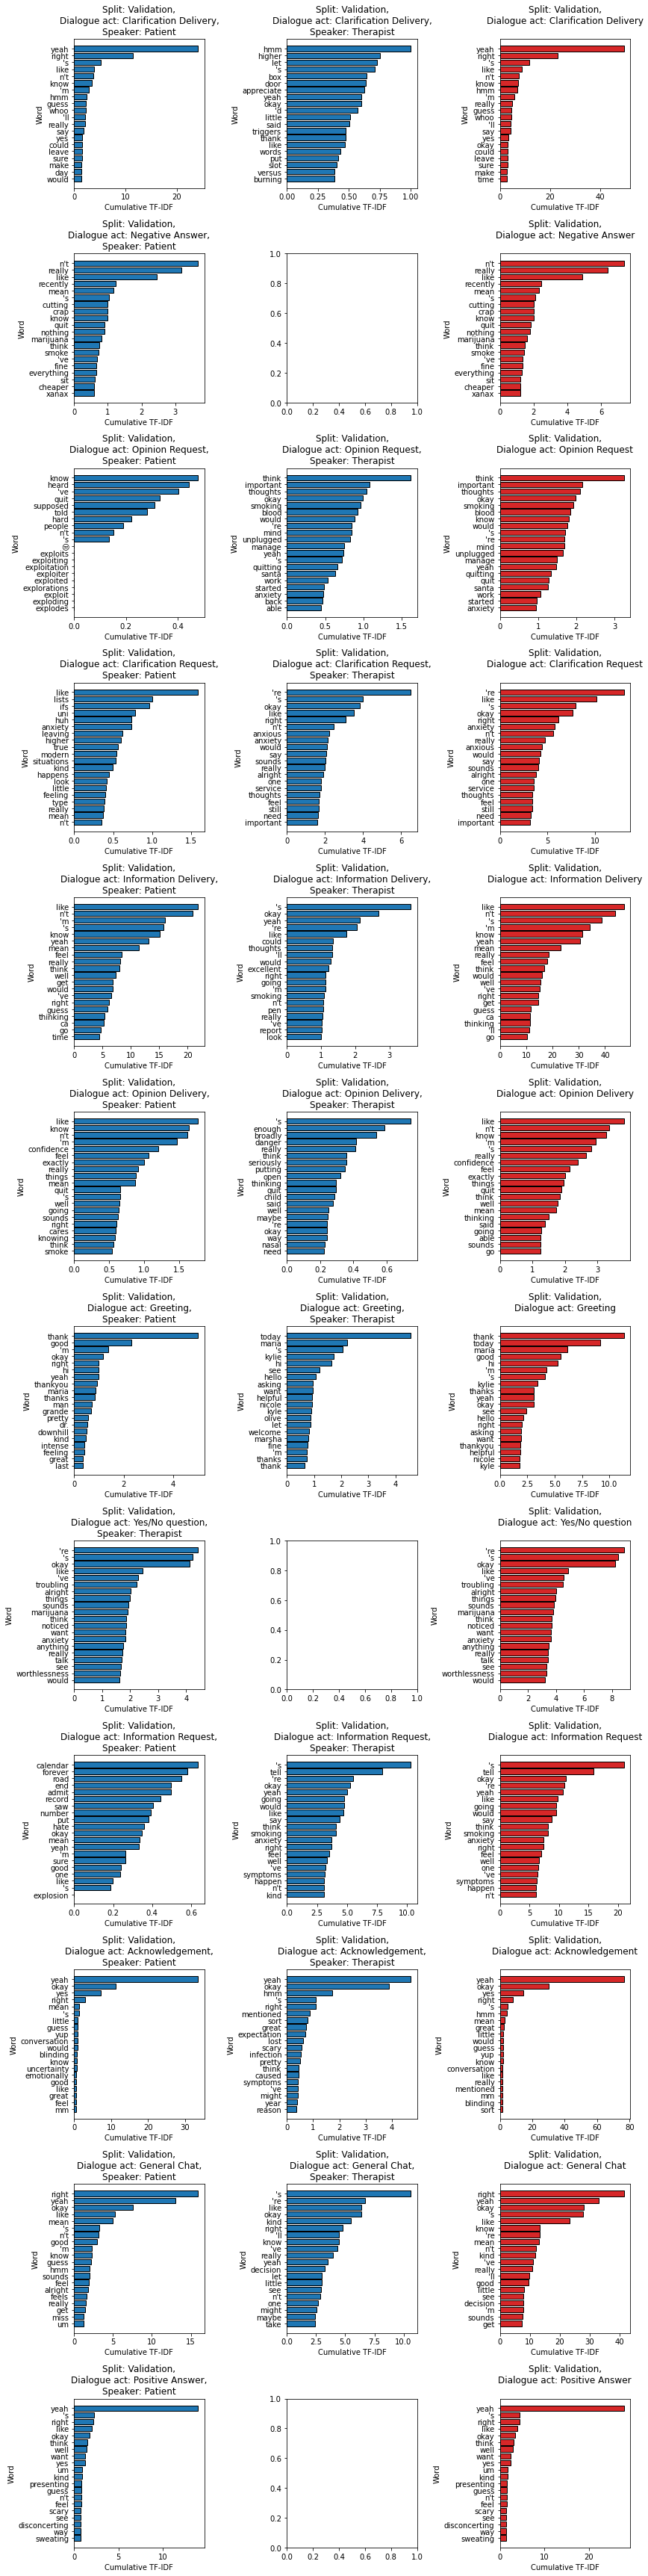

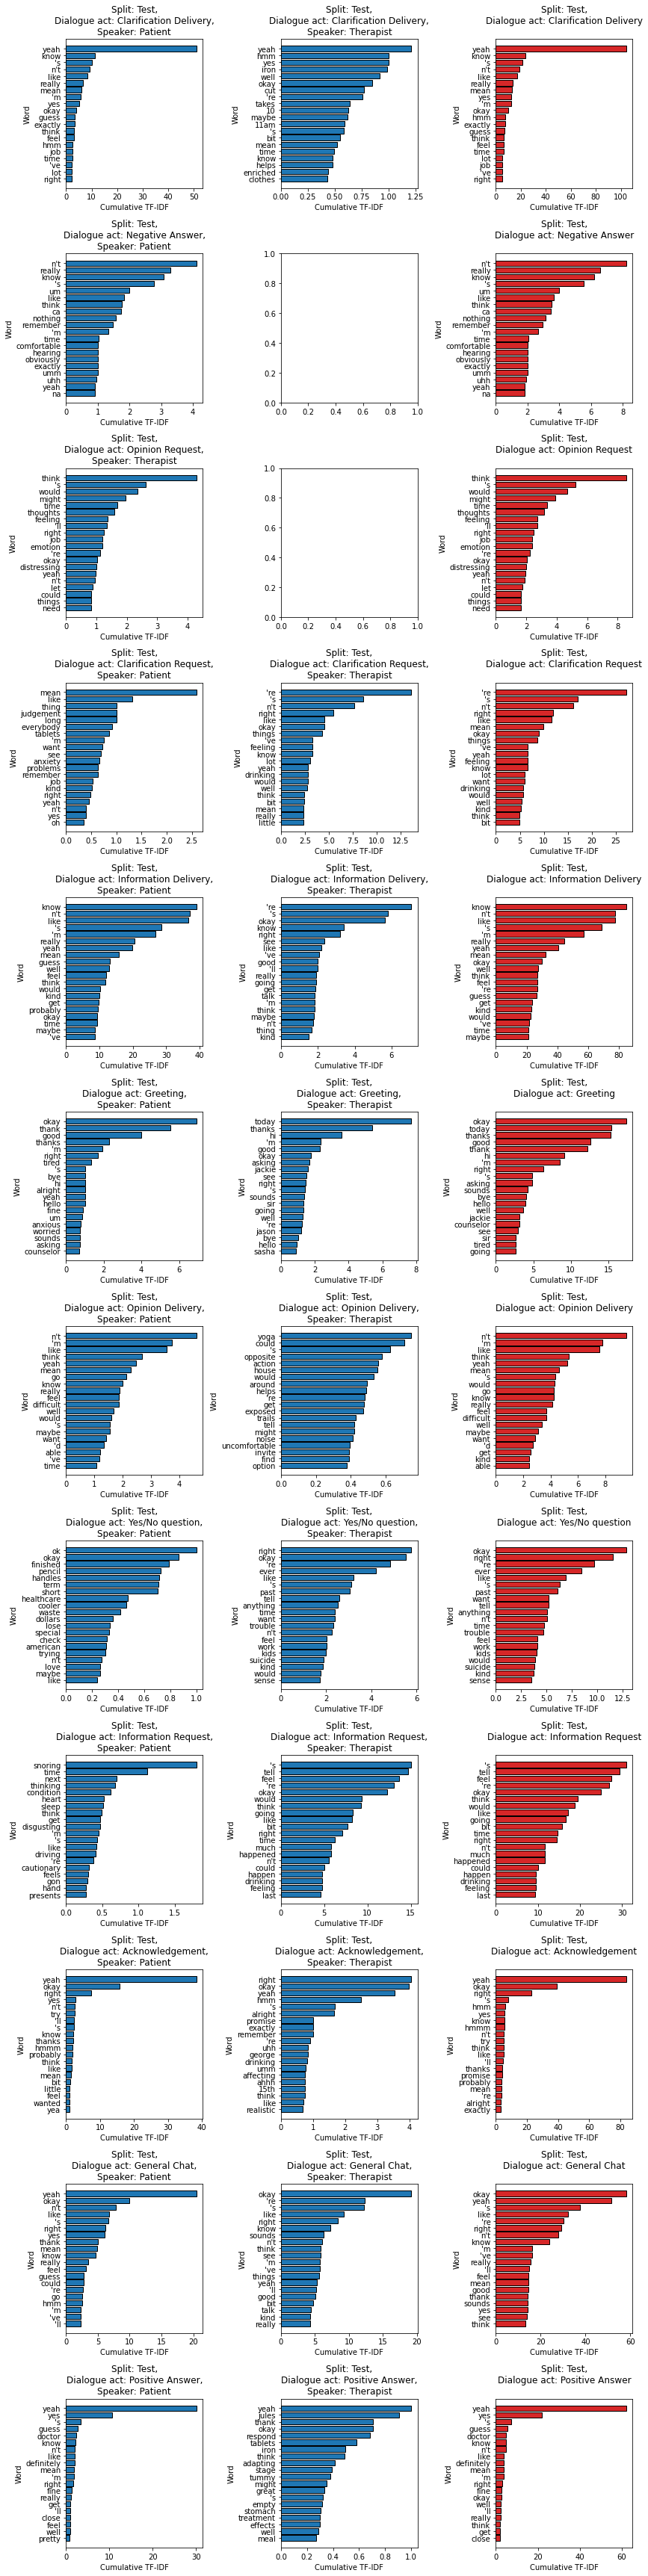

In [61]:
for i, (split, split_data) in enumerate(hope_data_vectors.items()):
    fig, axes = plt.subplots(nrows=12, ncols=3 , figsize=(12, 48))
    for j, (action, action_data) in enumerate(split_data.items()):
        X = []
        for k, (speaker, speaker_data) in enumerate(action_data.items()):
            x = np.asarray(speaker_data.sum(0))[0]
            X.append(x.copy())
            X.append(x.copy())
            idxs = x.argsort()[: -TOP_WORDS - 1 : -1][::-1]
            x = x[idxs]
            y = vocabulary[idxs]
            axes[j][k].barh(y, x, linewidth=1., edgecolor='0')
            axes[j][k].set_title(f'Split: {split.capitalize()},\nDialogue act: {action},\nSpeaker: {speaker}')
            axes[j][k].set_xlabel('Cumulative TF-IDF')
            axes[j][k].set_ylabel('Word')
        x = sum(X)
        idxs = x.argsort()[: -TOP_WORDS - 1 : -1][::-1]
        x = x[idxs]
        y = vocabulary[idxs]
        axes[j][-1].barh(y, x, linewidth=1., edgecolor='0', color='tab:red')
        axes[j][-1].set_title(f'Split: {split.capitalize()},\nDialogue act: {action}\n')
        axes[j][-1].set_xlabel('Cumulative TF-IDF')
        axes[j][-1].set_ylabel('Word')
        
    plt.tight_layout()
    plt.show()

#### Action type and speaker term distribution

In [62]:
hope_data_vectors = {
    split: {
        action: {
            speaker: tfidf.transform([sample['response'] for sample in samples]) 
            for speaker, samples in group_by([s for s in samples if s['speaker'] is not None], 'speaker').items()
        }
        for action, samples in group_by([s | {'action_type': DA_MAP[s['dialogue_act']]} for s in samples if s['corpus'] == 'HOPE' and s['dialogue_act'] is not None], 'action_type').items()
    } 
    for split, samples in data.items()
}

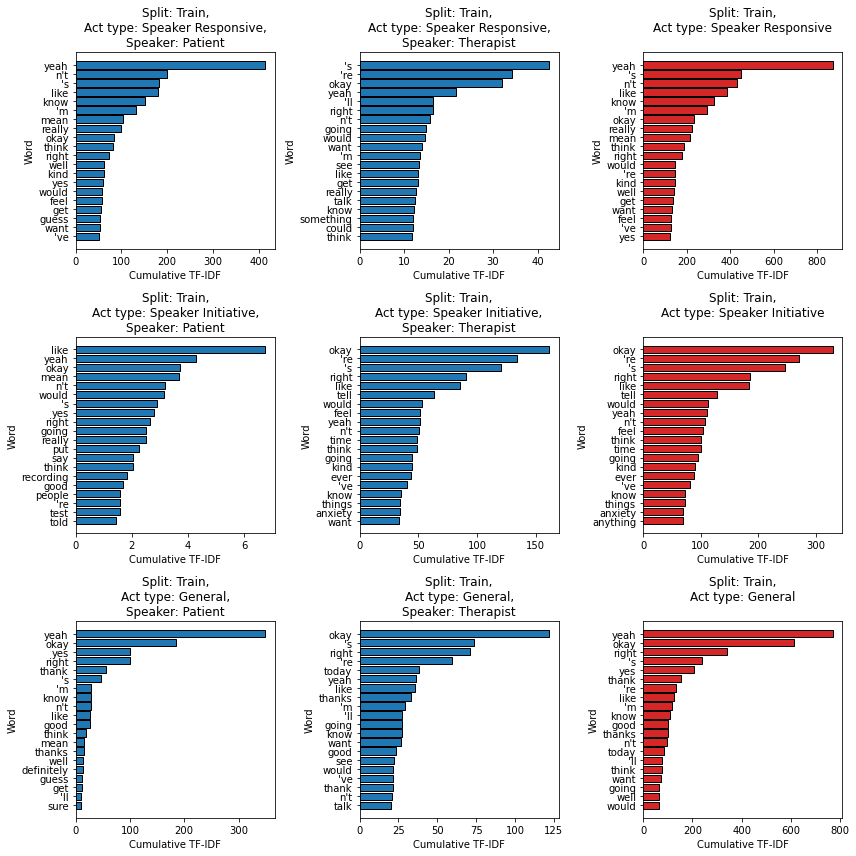

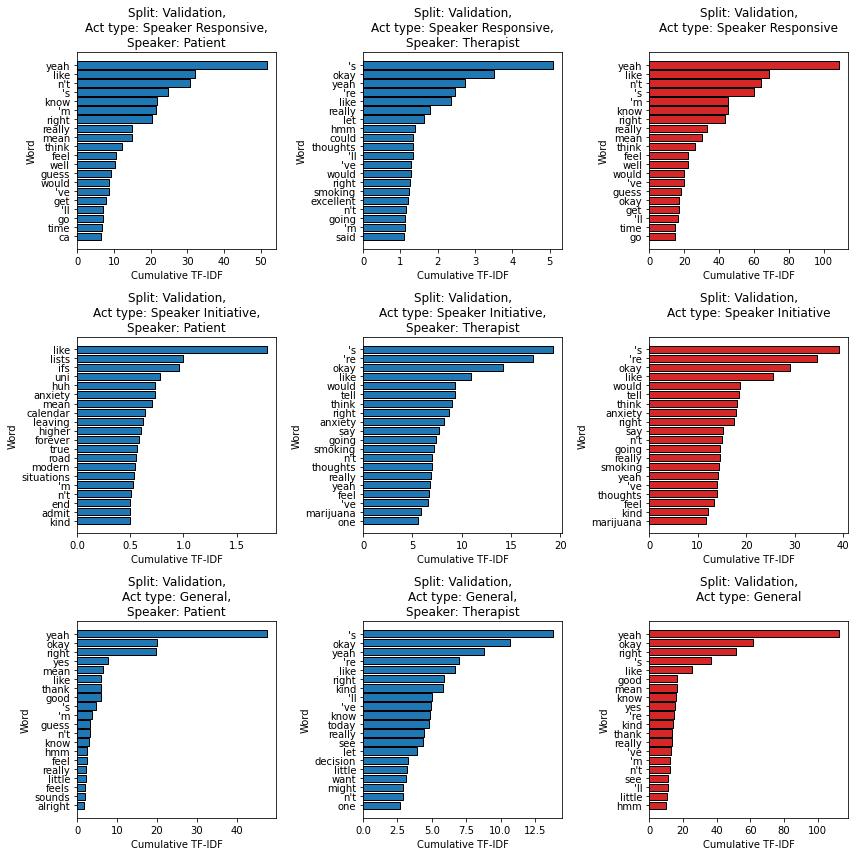

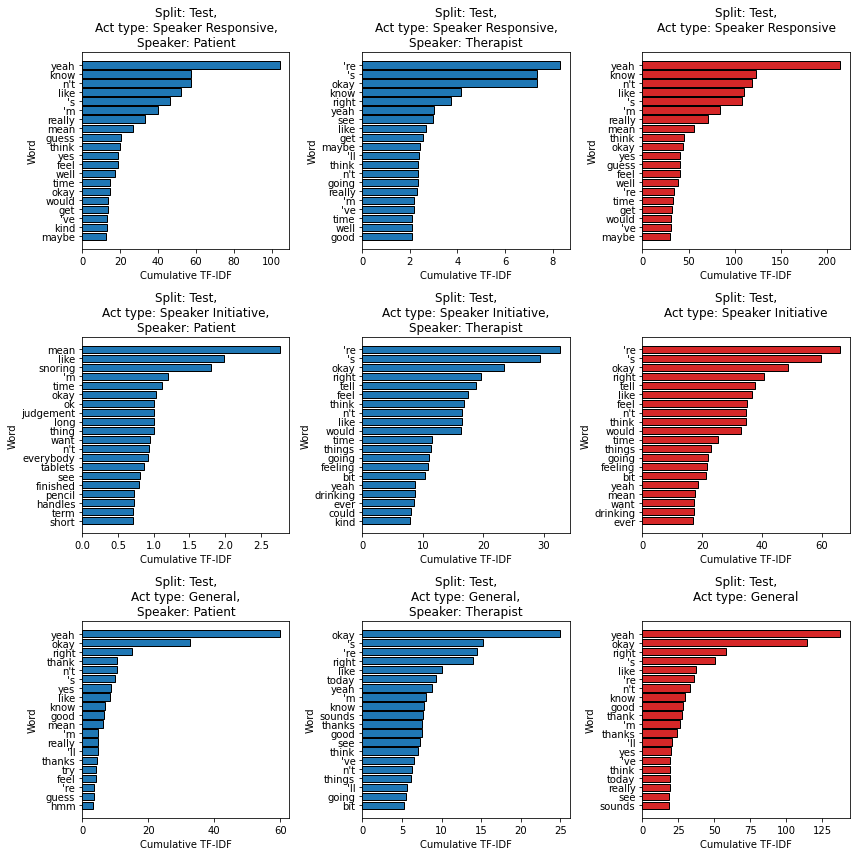

In [65]:
for i, (split, split_data) in enumerate(hope_data_vectors.items()):
    fig, axes = plt.subplots(nrows=3, ncols=3 , figsize=(12, 12))
    for j, (action, action_data) in enumerate(split_data.items()):
        X = []
        for k, (speaker, speaker_data) in enumerate(action_data.items()):
            x = np.asarray(speaker_data.sum(0))[0]
            X.append(x.copy())
            X.append(x.copy())
            idxs = x.argsort()[: -TOP_WORDS - 1 : -1][::-1]
            x = x[idxs]
            y = vocabulary[idxs]
            axes[j][k].barh(y, x, linewidth=1., edgecolor='0')
            axes[j][k].set_title(f'Split: {split.capitalize()},\nAct type: {action},\nSpeaker: {speaker}')
            axes[j][k].set_xlabel('Cumulative TF-IDF')
            axes[j][k].set_ylabel('Word')
        x = sum(X)
        idxs = x.argsort()[: -TOP_WORDS - 1 : -1][::-1]
        x = x[idxs]
        y = vocabulary[idxs]
        axes[j][-1].barh(y, x, linewidth=1., edgecolor='0', color='tab:red')
        axes[j][-1].set_title(f'Split: {split.capitalize()},\nAct type: {action}\n')
        axes[j][-1].set_xlabel('Cumulative TF-IDF')
        axes[j][-1].set_ylabel('Word')
        
    plt.tight_layout()
    plt.show()

#### Sentiment and speaker term distribution

In [75]:
hope_data_vectors = {
    split: {
        action: {
            speaker: tfidf.transform([sample['response'] for sample in samples]) 
            for speaker, samples in group_by([s for s in samples if s['speaker'] is not None], 'speaker').items()
        }
        for action, samples in group_by([s for s in samples if s['corpus'] == 'HOPE'], 'sentiment').items()
    } 
    for split, samples in data.items()
}

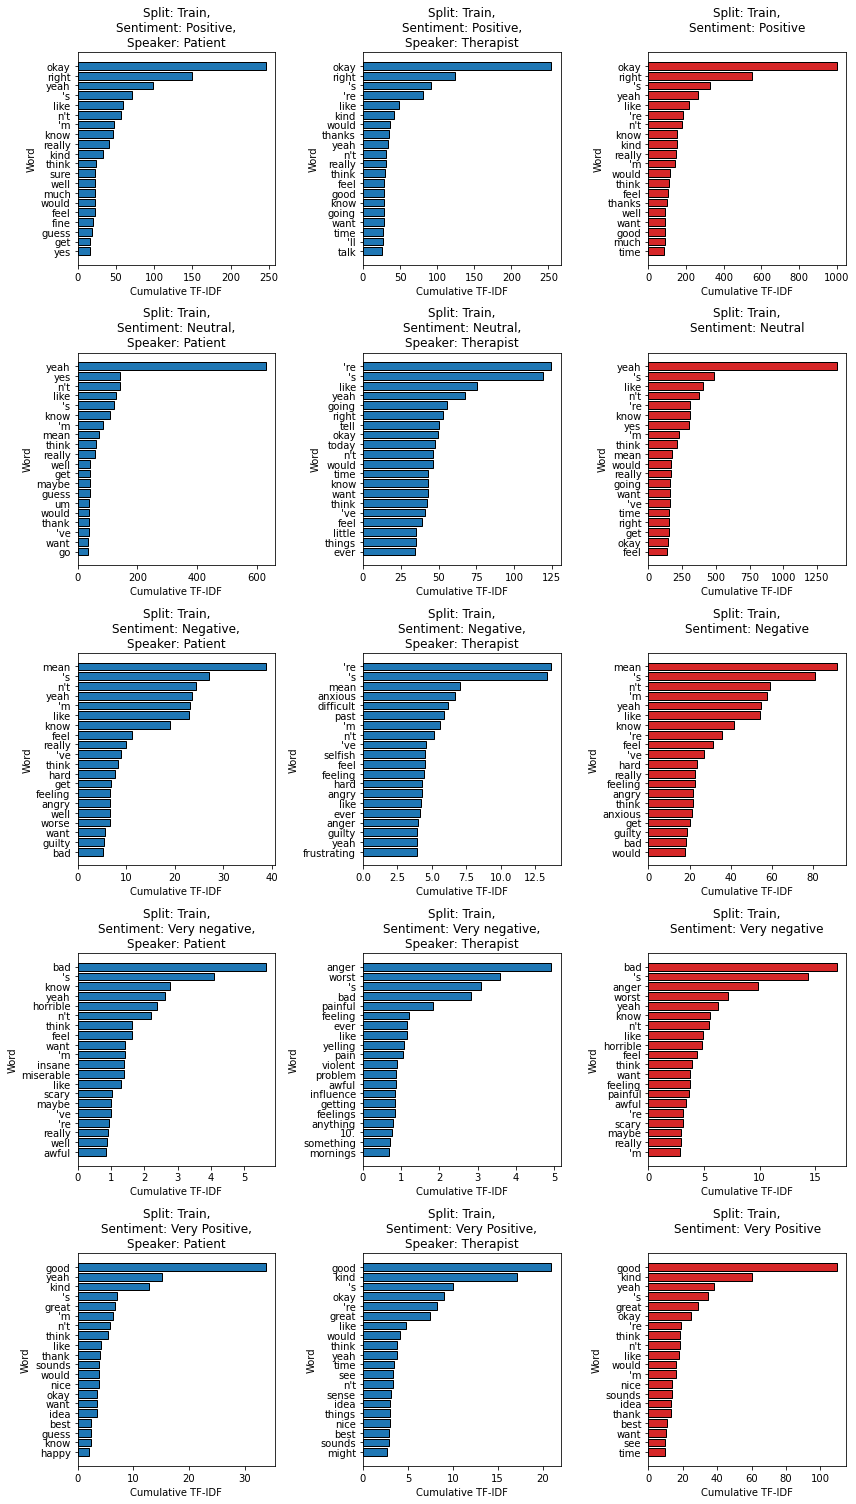

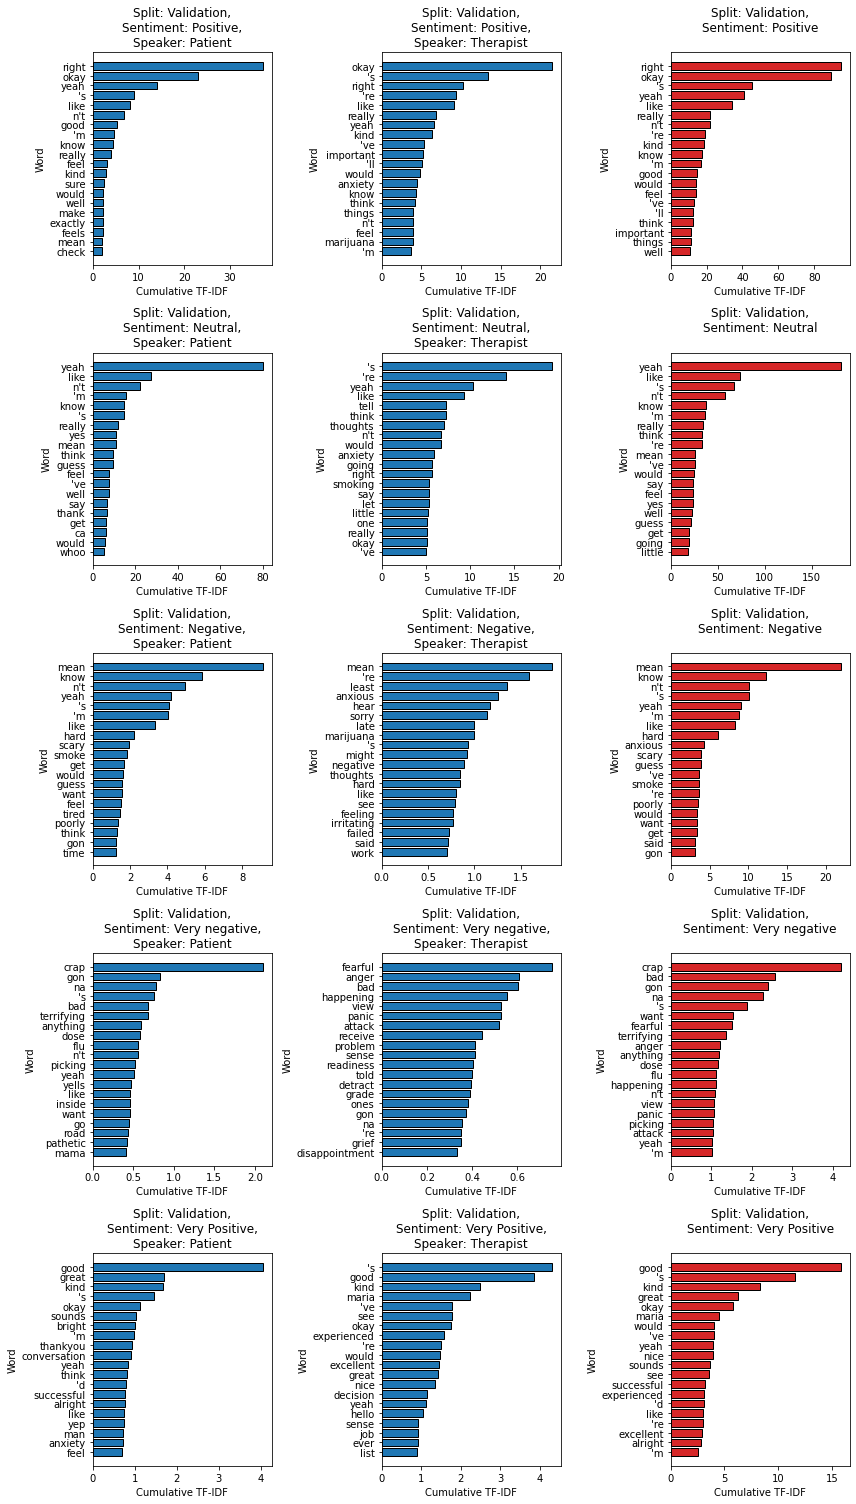

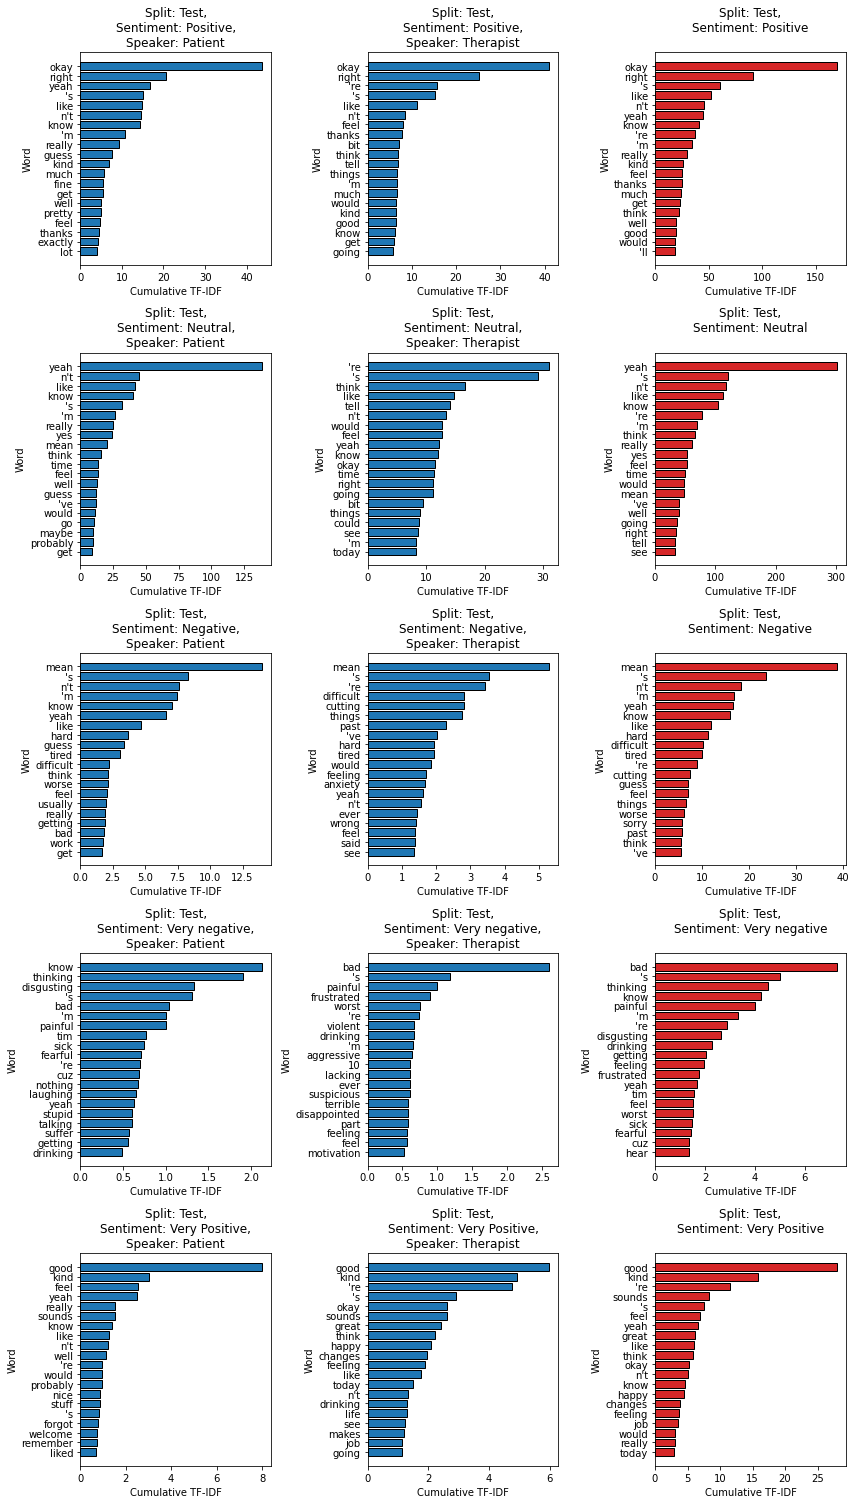

In [78]:
for i, (split, split_data) in enumerate(hope_data_vectors.items()):
    fig, axes = plt.subplots(nrows=5, ncols=3 , figsize=(12, 21))
    for j, (action, sentiment_data) in enumerate(split_data.items()):
        X = []
        for k, (speaker, speaker_data) in enumerate(sentiment_data.items()):
            x = np.asarray(speaker_data.sum(0))[0]
            X.append(x.copy())
            X.append(x.copy())
            idxs = x.argsort()[: -TOP_WORDS - 1 : -1][::-1]
            x = x[idxs]
            y = vocabulary[idxs]
            axes[j][k].barh(y, x, linewidth=1., edgecolor='0')
            axes[j][k].set_title(f'Split: {split.capitalize()},\nSentiment: {action},\nSpeaker: {speaker}')
            axes[j][k].set_xlabel('Cumulative TF-IDF')
            axes[j][k].set_ylabel('Word')
        x = sum(X)
        idxs = x.argsort()[: -TOP_WORDS - 1 : -1][::-1]
        x = x[idxs]
        y = vocabulary[idxs]
        axes[j][-1].barh(y, x, linewidth=1., edgecolor='0', color='tab:red')
        axes[j][-1].set_title(f'Split: {split.capitalize()},\nSentiment: {action}\n')
        axes[j][-1].set_xlabel('Cumulative TF-IDF')
        axes[j][-1].set_ylabel('Word')
        
    plt.tight_layout()
    plt.show()